<a href="https://colab.research.google.com/github/michpaulatto/AppliedGeophysicsExercises/blob/main/3_tt_lcurve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traveltime tomography exercise - L-curve
Created by Michele Paulatto, Imperial College London

https://github.com/michpaulatto/AppliedGeophysicsExercises

Developed for Google Colab

This is a script to calculate the L-curve for exercise 1.

In [1]:
%%bash
PYTHONPATH=""
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT &> setup.log
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX &>> setup.log
echo "Miniconda installed"

Miniconda installed


In [2]:
!conda install --channel defaults conda python=3.6 --yes &>> setup.log
!conda update --channel defaults --all --yes &>> setup.log
print("Anaconda updated and set up")
import sys
sys.path
_ = (sys.path.append("/usr/local/lib/python3.6/site-packages"))

!conda install pygimli -c gimli -c conda-forge --yes &>> setup.log
print("Pygimli installed")

Anaconda updated and set up
Pygimli installed


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics.traveltime import TravelTimeManager
from pygimli.viewer.mpl import drawMesh
pg.utils.units.quants['vel']['cMap'] = 'inferno_r'

20/01/21 - 21:19:58 - pyGIMLi - INFO - Creating default user configuration file at /root/.config/pygimli/config.json


# Geometry set up
Here we create some meshes that we will use to define the velocity models.
We create a mesh that will serve as our "true" model (mesh_for) and a mesh that will serve as a background model (mesh_bg). The true model contains two elliptical anomalies that we will try to recover with the traveltime inversion. The background model will be used as the starting model for the inversion.
The mesh file only contain information on the geometry of the model parameterisation and no information on the seismic velocity. 

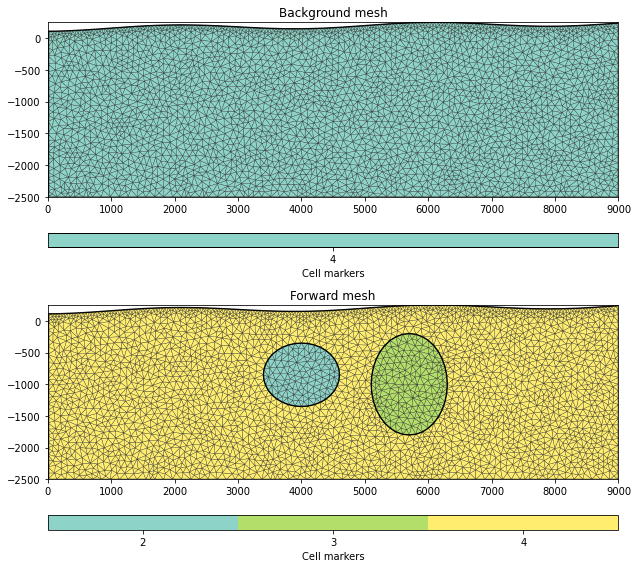

In [4]:
# Create elliptical anomalies. Youc an change the size and location of the anomalies to customise your model
# Anomaly 1:
magma = mt.createCircle(pos=[4000.0, -850.], segments=36, radius=[600.0, 500.0], marker=2,
                        area=8000.0)
# Anomaly 2:
pluton = mt.createCircle(pos=[5700.0, -1000.], segments=36, radius=[600.0, 800.0], marker=3,
                        area=8000.0)
# Define a function to create land topography 
def surf(x):
    y =150 - 40 * np.cos(2 * np.pi * 1/4000 * x) +x*0.01
    return y

# We define the location of sources here so that we can give each one a node in the mesh
# shots every 50 m at the surface
shotsx = np.arange(0., 9050.,50.0)
shotsy = surf(shotsx)
# Receivers every 500 m at the surface
obsx = np.arange(500.0, 9000.0, 500.)
obsy = surf(obsx)

# Create topography
topo = [[x,surf(x)] for x in shotsx]
topo.append([9000,-2500])
topo.append([0,-2500])

# Create main polygon for the mesh with topography as top surface
main = mt.createPolygon(topo,area=8000,isClosed=True, marker=4)
plc = main
    
# Merge polygons into a single mesh for true model and background model
# The variable quality sets the quality of the mesh
# The variable area sets the maximum area of each cell in the mesh in m^2.
mesh_for = mt.createMesh(plc + magma + pluton, quality=32, area=8000)
# The background model doesn't include the elliptical anomalies
mesh_bg = mt.createMesh(plc, quality=32, area=8000)

# Plot meshes
fig, ax = plt.subplots(2,1,figsize=(10,8))
pg.show(mesh_bg,markers=True, showMesh=True,ax=ax[0])
pg.show(mesh_for,markers=True, showMesh=True,ax=ax[1])
ax[0].set_title("Background mesh")
ax[1].set_title("Forward mesh")
fig.tight_layout()

# Define velocity model
Here we add velocity information to the meshes.
We create a background velocity by "hanging" a 1d velocity model to the surface topography. The true model is built by adding the velocity anomalies and a random perturbation to the background model. The velocity information is stored in separate files from the mesh files.

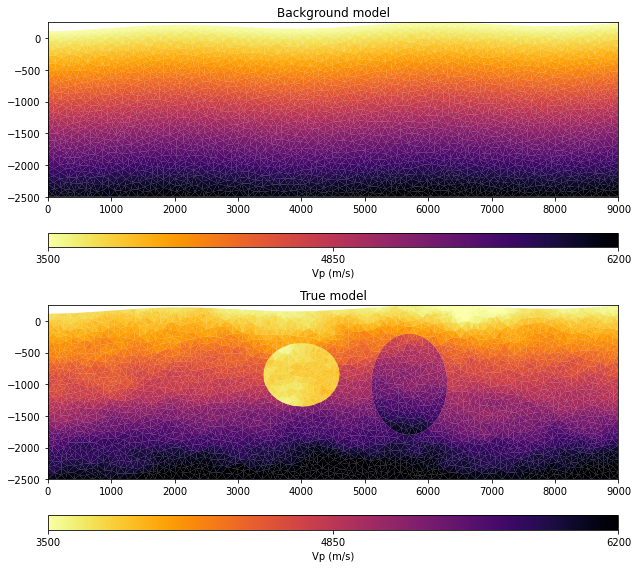

In [5]:
# Remove boundary markers
for boundary in mesh_for.boundaries():
    boundary.setMarker(0)
for boundary in mesh_bg.boundaries():
    boundary.setMarker(0)

# Initialise lists that will contain the velocity information
vel_for = []
vel_bg = []
# Define background velocity model
a = 3500  # Vp value at the surface in m/s
b = 1.0   # Vertical Vp gradient in (m/s)/m
# Create velocities "hanging" from topography
for node in mesh_bg.nodes():
    vel_bg.append(a+b*(abs(node.y()-surf(node.x()))))    
for node in mesh_for.nodes():
    vel_for.append(a+b*(abs(node.y()-surf(node.x()))))

# Add velocity info to mesh
vel_for = pg.meshtools.nodeDataToCellData(mesh_for,np.array(vel_for))
vel_bg = pg.meshtools.nodeDataToCellData(mesh_bg,np.array(vel_bg))

# Create reference model with forward mesh for plotting calculating velocity anomaly
vel_for_ref = []
for node in mesh_for.nodes():
    vel_for_ref.append(a+b*(abs(node.y()-surf(node.x()))))
vel_for_ref = pg.meshtools.nodeDataToCellData(mesh_for,np.array(vel_for_ref))


# Add anomalies to velocity model
c = 3600  # Vp value inside anomaly 1
d = 400   # Vp anomaly inside anomaly 2
for i,cell in enumerate(mesh_for.cells()):
    if cell.marker() == 2:
        vel_for[i] = c
    elif cell.marker() == 3:
        vel_for[i] = vel_for[i]+d

# Add random perturbations to true model. You can change the strength of the random perturbation to see how it affects the inversion.
strength = 100
random = pg.utils.generateGeostatisticalModel(mesh_for, I=[1000, 500])
vel_for = vel_for+random*strength     

# Plot background model and true model
fig, ax = plt.subplots(2,1,figsize=(10,8))
pg.show(mesh_bg, vel_bg, label="Vp (m/s)",ax=ax[0],cMap=pg.cmap('vel'), nLevs=3,cMin=3500,cMax=6200)
pg.show(mesh_for, vel_for, label="Vp (m/s)",ax=ax[1],cMap=pg.cmap('vel'), nLevs=3,cMin=3500,cMax=6200)
ax[0].set_title("Background model")
ax[1].set_title("True model")
fig.tight_layout()

# Experiment set up
Here we define the acquisition geometry of the experiment and define the variable that we need to simulate the ray propagation.

In [6]:
from itertools import product

# Define shot locations
shots = np.zeros((len(shotsx), 2)) 
shots[:, 0] = shotsx  # x
shots[:, 1] = shotsy

# Define receiver locations
obss = np.zeros((len(obsx), 2)) 
obss[:, 0] = obsx  # x
obss[:, 1] = obsy

# Create labels for the shots
shotsn = np.arange(len(shotsx))
# Find a label for each receiver that correspond to the shot at that position
obsn = []
for i in shotsn:
    if shotsx[i] in obsx:
        obsn.append(i)     

# Define source-receiver pairs 
rays = list(product(obsn,shotsn))

# Remove pairs were source and receiver are close to each other
# You can modify this to exclude short offsets or long offsets from your inversion
remove=[]
for i,r in enumerate(rays):
    if abs(r[0] - r[1]) < 2 :
        remove.append(r)        
for r in remove:
    rays.remove(r)
    
# Create empty data container
scheme = pg.DataContainer()        

# Add shots and receivers as "sensors". Pygimli doesn't distinguish
# between sources and receivers. They are all called "sensors".
for i in shotsn:
    scheme.createSensor((shotsx[i],shotsy[i]))

# Add measurements, i.e. read the source-receiver pairs defined above
rays = np.array(rays)
scheme.resize(len(rays))
scheme["s"] = rays[:, 0]
scheme["g"] = rays[:, 1]
scheme["valid"] = np.ones(len(rays))
scheme.registerSensorIndex("s")
scheme.registerSensorIndex("g")
print("Done")

Done


# Calculate traveltimes and draw raypaths
Here we calculate synthetic traveltimes for the true model. These will be our data for the following inversion.
The parameter "secnodes" can be increased to make the ray tracing more accurate.
The traveltimes are calculate by finding the path of minimum traveltime between each source and receiver pair. This means that we calculate only the first arrival traveltimes. Later ariving phases may exist but cannot be calculated with this method.

In [7]:
# Initialise traveltime manager
vel_run = vel_for
mesh_run = mesh_for
tt = TravelTimeManager()
secnodes=6  # Number of secondary nodes

pg.tic()
syn = tt.simulate(mesh=mesh_run, scheme=scheme, slowness=1./vel_run,secNodes=secnodes,
                 noiseAbs=0.0005, seed=1337, verbose=1,debug=True)
pg.toc("Raytracing with %d secondary nodes:" % secnodes)
print(syn)
print("Done")

20/01/21 - 21:22:04 - pyGIMLi - INFO - Creating refined mesh (secnodes: 6) to solve forward task.


Raytracing with 6 secondary nodes: Elapsed time is 16.70 seconds.
Data: Sensors: 181 data: 3026, nonzero entries: ['err', 'g', 's', 't', 'valid']
Done


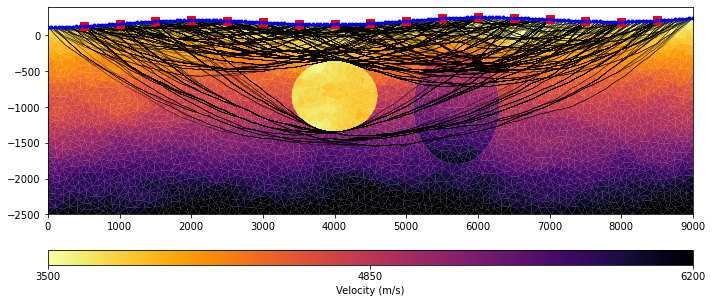

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
# Plot the velocity model
pg.show(mesh_run, vel_run, ax=ax, label="Velocity (m/s)", hold=True,
       logScale=False, cMap=pg.cmap('vel'), nLevs=3,cMin=3500,cMax=6200)

# Plot rays
tt.drawRayPaths(ax=ax, model=vel_run, color="k", lw=0.3, alpha=0.5)
ax.plot(obsx, obsy, "rs", ms=8)     # plot receivers as red squares
ax.plot(shotsx, shotsy, "bo", ms=3) # plot shots as blue dots
ax.set_ylim(mesh_run.ymin(), 400)   # set y axis limits
fig.tight_layout()

Notice how the rays "avoid" the low velocity anomaly. Think about why this is the case. Remember that we are calculating the first arrival traveltimes. What will be the consequence of the rays avoiding the low velocity anomaly on the ability of the inversion to recover the structure?

 # Tuning the regularization: L-curve

The inversion is repeated with multiple values of lambda to build an L-curve

In [9]:
# Test a wide range of lambda values
lambdas = [1e3,3e3,1e4,1e5,1e6,1e7,1e8]

chis = []
dnorms = []
mnorms = []
mnormsmanual = []
phis=[]
relrms=[]
absrms=[]
errs=[]
models=[]

for i,lam in enumerate(lambdas):
# We will look into it in detail in the next exercise.
    invmodel=tt.invert(syn, mesh=mesh_bg, startModel=1./vel_bg, secNodes=5,zWeight=0.5, 
          verbose=1, maxIter=20, lam=lam, dPhi=1)
#    print(tt.inv.)
    tt.inv.errorVals
    chis.append(tt.inv.chi2())
    dnorms.append(tt.inv.phiData())
    mnorms.append(tt.inv.phiModel())
    phis.append(tt.inv.phi())
    relrms.append(tt.inv.relrms())
    errs.append(tt.inv.errorVals)
    rough=pg.solver.cellDataToCellGrad2(mesh_bg,invmodel)
    mnormsmanual.append(pg.math.dot(rough,rough)/len(rough))
    models.append(invmodel)

    print(lam,tt.inv.chi2(),tt.inv.phi(),tt.inv.phiData(),tt.inv.phiModel(),tt.inv.relrms())  # Look at the data fit


20/01/21 - 21:22:48 - pyGIMLi - INFO - Found 1 regions.
20/01/21 - 21:22:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
20/01/21 - 21:22:48 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
20/01/21 - 21:22:48 - pyGIMLi - INFO - Startmodel set from given array. 5420 [0.0002806728764821717,...,0.00016755937742097502]
20/01/21 - 21:22:48 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.TravelTimeManager.TravelTimeDijkstraModelling object at 0x7f6f19938d88>
Data transformation: <pygimli.core._pygimli_.RTrans object at 0x7f6f19938810>
Model transformation (cumulative):
	 0 <pygimli.core._pygimli_.RTransLogLU object at 0x7f6f123f0300>
min/max (data): 0.026/1.98
min/max (error): 0.025%/1.92%
min/max (start model): 1.6e-04/2.8e-04
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 78.65 (dPhi = 6.14%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 72.41 (dPhi = 7.92%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 65.7 (dPhi = 9.25%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 59.44 (dPhi = 9.51%) lam: 100

20/01/21 - 21:35:37 - pyGIMLi - INFO - Found 1 regions.
20/01/21 - 21:35:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
20/01/21 - 21:35:37 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


chi² = 2.59 (dPhi = 11.43%) lam: 1000.0
1000.0 2.588959236725064 9118.322131863066 7834.190650330044 1.284131481533021 0.28335273021355323


20/01/21 - 21:35:37 - pyGIMLi - INFO - Startmodel set from given array. 5420 [0.0002806728764821717,...,0.00016755937742097502]
20/01/21 - 21:35:37 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.TravelTimeManager.TravelTimeDijkstraModelling object at 0x7f6f19938d88>
Data transformation: <pygimli.core._pygimli_.RTrans object at 0x7f6f19938810>
Model transformation (cumulative):
	 0 <pygimli.core._pygimli_.RTransLogLU object at 0x7f6f123f0620>
min/max (data): 0.026/1.98
min/max (error): 0.025%/1.92%
min/max (start model): 1.6e-04/2.8e-04
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 45.14 (dPhi = 18.17%) lam: 3000.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 41.71 (dPhi = 7.58%) lam: 3000.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 35.79 (dPhi = 14.14%) lam: 3000.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 27.77 (dPhi = 22.28%) lam:

20/01/21 - 21:48:59 - pyGIMLi - INFO - Found 1 regions.
20/01/21 - 21:48:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
20/01/21 - 21:48:59 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


chi² = 1.58 (dPhi = 1.73%) lam: 3000.0
3000.0 1.5795500087715848 8058.313079006385 4779.718326542816 1.0928649174878564 0.27416731326356647


20/01/21 - 21:49:00 - pyGIMLi - INFO - Startmodel set from given array. 5420 [0.0002806728764821717,...,0.00016755937742097502]
20/01/21 - 21:49:00 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.TravelTimeManager.TravelTimeDijkstraModelling object at 0x7f6f19938d88>
Data transformation: <pygimli.core._pygimli_.RTrans object at 0x7f6f19938810>
Model transformation (cumulative):
	 0 <pygimli.core._pygimli_.RTransLogLU object at 0x7f6f125490d0>
min/max (data): 0.026/1.98
min/max (error): 0.025%/1.92%
min/max (start model): 1.6e-04/2.8e-04
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 32.89 (dPhi = 44.25%) lam: 10000.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 11.27 (dPhi = 64.92%) lam: 10000.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 6.88 (dPhi = 38.59%) lam: 10000.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 4.46 (dPhi = 34.11%) la

20/01/21 - 21:55:41 - pyGIMLi - INFO - Found 1 regions.
20/01/21 - 21:55:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
20/01/21 - 21:55:41 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


chi² = 0.99 (dPhi = 4.1%) lam: 10000.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.99)                   #
################################################################################
10000.0 0.9926245693706784 13140.975094335656 3003.681946915673 1.0137293147419983 0.27345732632948294


20/01/21 - 21:55:41 - pyGIMLi - INFO - Startmodel set from given array. 5420 [0.0002806728764821717,...,0.00016755937742097502]
20/01/21 - 21:55:41 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.TravelTimeManager.TravelTimeDijkstraModelling object at 0x7f6f19938d88>
Data transformation: <pygimli.core._pygimli_.RTrans object at 0x7f6f19938810>
Model transformation (cumulative):
	 0 <pygimli.core._pygimli_.RTransLogLU object at 0x7f6f12549260>
min/max (data): 0.026/1.98
min/max (error): 0.025%/1.92%
min/max (start model): 1.6e-04/2.8e-04
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 7.77 (dPhi = 70.46%) lam: 100000.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 2.99 (dPhi = 55.37%) lam: 100000.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1.94 (dPhi = 27.35%) lam: 100000.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 1.82 (dPhi = 5.01%) la

20/01/21 - 22:01:07 - pyGIMLi - INFO - Found 1 regions.
20/01/21 - 22:01:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
20/01/21 - 22:01:07 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


chi² = 1.46 (dPhi = 0.82%) lam: 100000.0
################################################################################
#                  Abort criteria reached: dPhi = 0.82 (< 1%)                  #
################################################################################
100000.0 1.462512754864771 103026.7162959696 4425.563596220797 0.986011526997488 0.2867870717712986


20/01/21 - 22:01:07 - pyGIMLi - INFO - Startmodel set from given array. 5420 [0.0002806728764821717,...,0.00016755937742097502]
20/01/21 - 22:01:07 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.TravelTimeManager.TravelTimeDijkstraModelling object at 0x7f6f19938d88>
Data transformation: <pygimli.core._pygimli_.RTrans object at 0x7f6f19938810>
Model transformation (cumulative):
	 0 <pygimli.core._pygimli_.RTransLogLU object at 0x7f6f125491c0>
min/max (data): 0.026/1.98
min/max (error): 0.025%/1.92%
min/max (start model): 1.6e-04/2.8e-04
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 5.97 (dPhi = 60.78%) lam: 1000000.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 3.76 (dPhi = 19.54%) lam: 1000000.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 3.3 (dPhi = 5.32%) lam: 1000000.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 3.15 (dPhi = 1.53%) l

20/01/21 - 22:04:25 - pyGIMLi - INFO - Found 1 regions.
20/01/21 - 22:04:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
20/01/21 - 22:04:25 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


chi² = 3.04 (dPhi = 0.69%) lam: 1000000.0
################################################################################
#                  Abort criteria reached: dPhi = 0.69 (< 1%)                  #
################################################################################
1000000.0 3.0421242310284082 980524.2344237524 9205.467923091963 0.9713187665006604 0.3347460407941026


20/01/21 - 22:04:25 - pyGIMLi - INFO - Startmodel set from given array. 5420 [0.0002806728764821717,...,0.00016755937742097502]
20/01/21 - 22:04:25 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.TravelTimeManager.TravelTimeDijkstraModelling object at 0x7f6f19938d88>
Data transformation: <pygimli.core._pygimli_.RTrans object at 0x7f6f19938810>
Model transformation (cumulative):
	 0 <pygimli.core._pygimli_.RTransLogLU object at 0x7f6f125490d0>
min/max (data): 0.026/1.98
min/max (error): 0.025%/1.92%
min/max (start model): 1.6e-04/2.8e-04
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 13.98 (dPhi = 21.87%) lam: 10000000.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 13.14 (dPhi = 1.19%) lam: 10000000.0
--------------------------------------------------------------------------------
inv.iter 4 ... 

20/01/21 - 22:06:44 - pyGIMLi - INFO - Found 1 regions.
20/01/21 - 22:06:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
20/01/21 - 22:06:44 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


chi² = 13.01 (dPhi = 0.22%) lam: 10000000.0
################################################################################
#                  Abort criteria reached: dPhi = 0.22 (< 1%)                  #
################################################################################
10000000.0 13.007631427729716 9700533.676994357 39361.092700310124 0.9661172584294047 0.449121512806954


20/01/21 - 22:06:45 - pyGIMLi - INFO - Startmodel set from given array. 5420 [0.0002806728764821717,...,0.00016755937742097502]
20/01/21 - 22:06:45 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.TravelTimeManager.TravelTimeDijkstraModelling object at 0x7f6f19938d88>
Data transformation: <pygimli.core._pygimli_.RTrans object at 0x7f6f19938810>
Model transformation (cumulative):
	 0 <pygimli.core._pygimli_.RTransLogLU object at 0x7f6f125490d0>
min/max (data): 0.026/1.98
min/max (error): 0.025%/1.92%
min/max (start model): 1.6e-04/2.8e-04
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 87.06 (dPhi = 2.46%) lam: 100000000.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 86.08 (dPhi = 0.05%) lam: 100000000.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 85.88 (dPhi = 0.01%) lam: 100000000.0
################################################################################
#                  Abort criteria r

# Plotting the L-curve
Here we plot the L-curve. Use the plot to choose the optimal regularisation parameter (lambda). 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

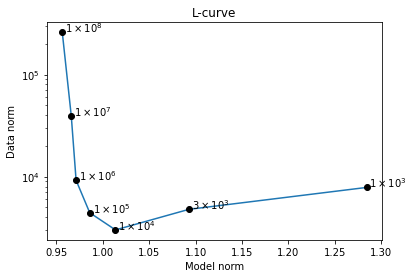

In [26]:
pmnorms=np.array(mnorms[:])
pdnorms=np.array(dnorms[:])
pmnormsmanual=np.array(mnormsmanual[:])
plambdas=np.array(lambdas[:])
pchi=np.array(chis[:])

import math
fig, ax2 = plt.subplots(1,1,figsize=(6,4))

def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

ax2.plot(pmnorms,pdnorms)
ax2.plot(pmnorms,pdnorms,"ok")
for i,x in enumerate(pmnorms):
  label="${0:s}$".format(as_si(lambdas[i],0))
  ax2.text(x+0.003,pdnorms[i],label)
ax2.set_yscale('log')
ax2.set_title("L-curve")
ax2.axes.set_xlabel('Model norm')
ax2.axes.set_ylabel('Data norm')

# Optional: save and download the figure
# fig.savefig("lcurve.pdf", bbox_inches='tight')
#from google.colab import files
#files.download( "/content/lcurve.pdf" ) 
